<a name="0"></a> 

# Time Series Forecasting 


The dataset used for this task is a Kaggle dataset consisting of daily climate measurements for a city called Delhi in India including mean temperature, humidity, wind speed, and mean pressure. This task will take the humidity and wind speed measurements as two univariate time series and predict forecasts for each sequence. 

* [Dataset Link](https://www.kaggle.com/sumanthvrao/daily-climate-time-series-data) 

---

## Models 

* **ARIMA: Autoregressive Integrated Moving Average** 
* **RNN: Recurrent Neural Network** 
* **CNN: Temporal Convolutional Neural Network** 

---

## Notebook Outline 

* [1. Load and Plot Data](#1) 
* [2. Forecasting Humidity](#2) 
  * [2.1 Autoregressive Integrated Moving Average](#2-1) 
  * [2.2 Recurrent Neural Network](#2-2) 
  * [2.3 Temporal Convolutional Network](#2-3) 
* [3. Forecasting Wind Speed](#3) 
  * [3.1 Autoregressive Integrated Moving Average](#3-1) 
  * [3.2 Recurrent Neural Network](#3-2) 
  * [3.3 Temporal Convolutional Network](#3-3) 
* [4. Summary and Conclusion](#4) 

--- 


In [1]:
import sys 
sys.path.append('../') 

import warnings 
warnings.filterwarnings('ignore') 

import pandas as pd 
from dspML import plot, utils 
from dspML.preprocessing import sequence 
from dspML.models.sequence import arima, nnetfc 
from dspML.evaluation import ForecastEval 

<a name="1"></a> 

# 1. Load and Plot Data 

* [Outline](#0) 


In [2]:
# data paths 
path_train = '../dspML/datasets/daily_climate/DailyDelhiClimateTrain.csv' 
path_test = '../dspML/datasets/daily_climate/DailyDelhiClimateTest.csv' 

# load full dataset 
df = pd.read_csv(path_train) 
df = df.append(pd.read_csv(path_test)) 
df['date'] = pd.to_datetime(df['date'], yearfirst=True) 
df.set_index('date', inplace=True) 
df.drop(['meantemp', 'meanpressure'], axis=1, inplace=True) 
print('Data Dimensions: ', df.shape) 
df.head() 

Data Dimensions:  (1576, 2)


,humidity,wind_speed
date,,
2013-01-01,84.500000,0.000000
2013-01-02,92.000000,2.980000
2013-01-03,87.000000,4.633333
2013-01-04,71.333333,1.233333
2013-01-05,86.833333,3.700000


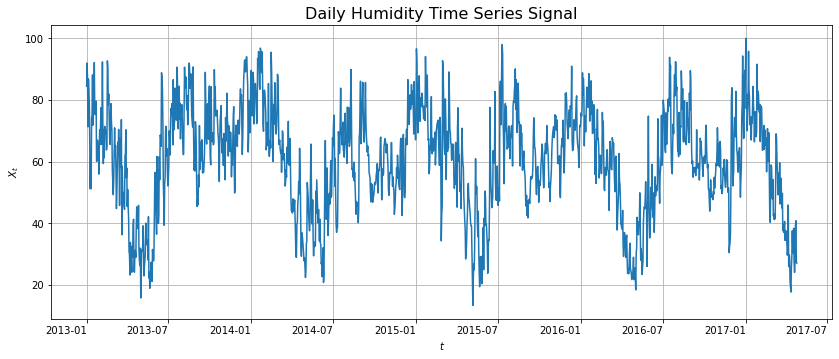

In [3]:
# plot humidity 
plot.signal_pd(df['humidity'], title='Daily Humidity Time Series Signal') 

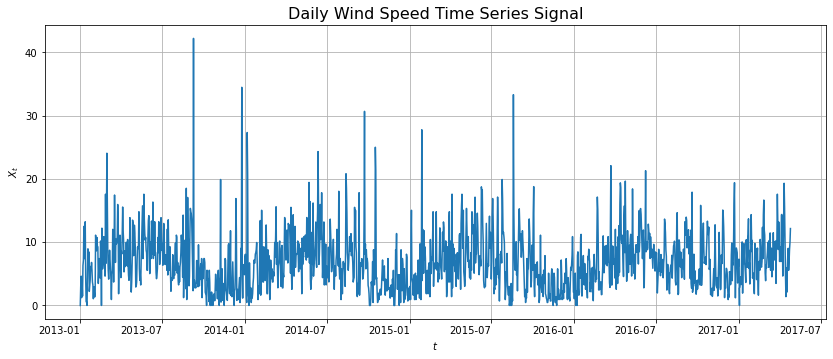

In [4]:
# plot wind speed 
plot.signal_pd(df['wind_speed'], title='Daily Wind Speed Time Series Signal') 

<a name="2"></a> 

# 2. Forecasting Humidity  

* [Outline](#0) 
* [Section 3 Outline](#3) 
* [Summary and Conclusion](#4) 

---

## Section Outline 

* [2.1 Autoregressive Integrated Moving Average](#2-1) 
* [2.2 Recurrent Neural Network](#2-2) 
* [2.3 Temporal Convolutional Network](#2-3) 

---

## Explore Humidity Signal 

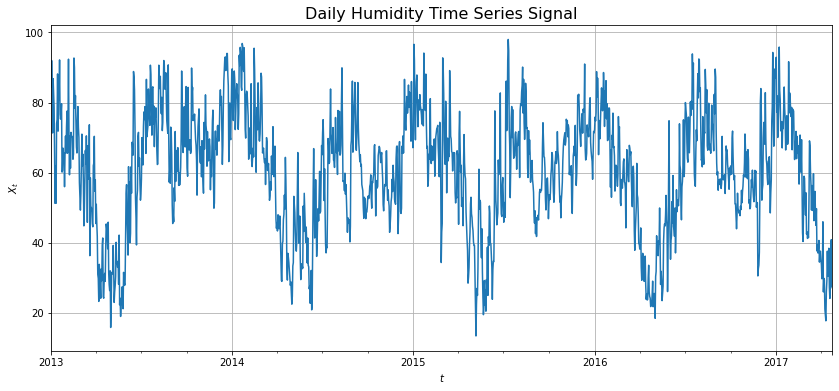

In [5]:
# extract humidity signal 
y = df['humidity'].resample('D').mean() 
plot.signal_pd(y, title='Daily Humidity Time Series Signal') 

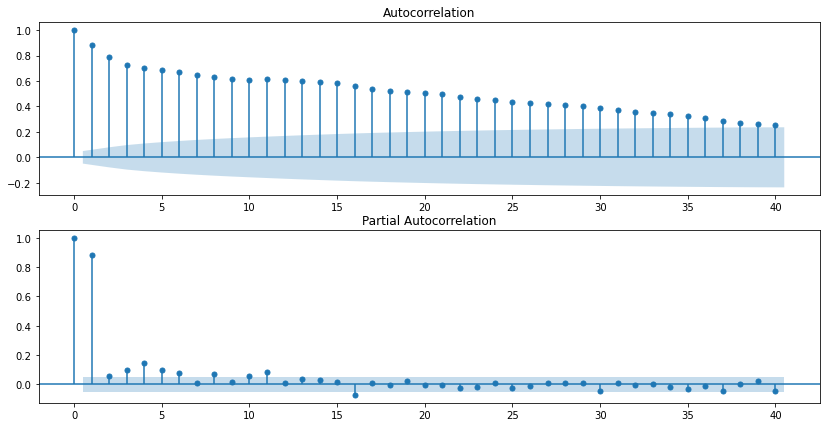

In [6]:
# plot ACF/PACF 
plot.p_acf(y, lags=40) 

The autocorrelation function and partial autocorrelation function indicate that there are no seasonal dependencies up to 40 lags. Since the data is collected daily, plot lags past a year to see if the data are periodic yearly. 

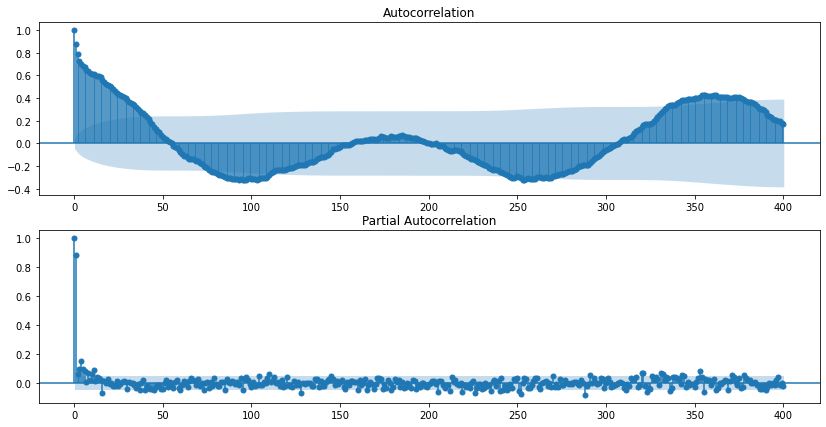

In [7]:
# plot ACF/PACF 
plot.p_acf(y, lags=400) 

There is still no indication of a seasonal dependency even though it looks like there would be in the time series plot. Test for stationarity with the Augmented Dickey Fuller test. 

In [8]:
# ADF test 
utils.ADF_test(y) 


Augmented Dickey-Fuller Test:

Test Statistic            -3.636648
p-val                      0.005098
Num. Lags                 15.000000
Num. Observations       1559.000000
Critical Value (1%)       -3.434551
Critical Value (5%)       -2.863396
Critical Value (10%)      -2.567758
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


<a name="2-1"></a> 

# 2.1 Autoregressive Integrated Moving Average 

* [Outline](#0) 
* [Section 2 Outline](#2) 

---

## Topic Sections 

* [Define Model](#2-1-1) 
* [Evaluate Model](#2-1-2) 
* [Predict and Evaluate 7-Day Forecast](#2-1-3) 
* [Plot Predicted Forecast](#2-1-4) 

---

## Split Data 

In [9]:
# train and test data 
fc_hzn = 7 
y_train, y_test = sequence.temporal_split(y, fc_hzn) 

<a name="2-1-1"></a> 

## Define Model 

Since the ACF and PACF indicate no obvious seasonality, define an ARIMA model without a seasonal adjustment. The range of each parameter $(p, d, q)$ will be set to $[0, 2]$ and will run an automatic ARIMA function defined to fit all options of parameters. The model with the lowest AIC will be returned. 


In [10]:
# define and fit model 
model = arima.AutoARIMA(y_train, verbose=True) 

ARIMA(0, 0, 0)x(0, 0, 0, 0) | AIC = 17437.917144506577
ARIMA(0, 0, 1)x(0, 0, 0, 0) | AIC = 15573.512462723871
ARIMA(0, 1, 0)x(0, 0, 0, 0) | AIC = 11042.70215074212
ARIMA(0, 1, 1)x(0, 0, 0, 0) | AIC = 11011.618144788728
ARIMA(1, 0, 0)x(0, 0, 0, 0) | AIC = 11049.234935386732
ARIMA(1, 0, 1)x(0, 0, 0, 0) | AIC = 11020.438975969728
ARIMA(1, 1, 0)x(0, 0, 0, 0) | AIC = 11022.096833909152
ARIMA(1, 1, 1)x(0, 0, 0, 0) | AIC = 10882.790795382465
                               SARIMAX Results                                
Dep. Variable:               humidity   No. Observations:                 1568
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5438.395
Date:                Fri, 18 Sep 2020   AIC                          10882.791
Time:                        19:16:25   BIC                          10898.862
Sample:                    01-01-2013   HQIC                         10888.765
                         - 04-17-2017                                         
Covarian

The ARIMA model parameters that yield the optimal AIC are $(p, d, q)=(1, 1, 1)$. 

---

<a name="2-1-2"></a> 

## Evaluate Model

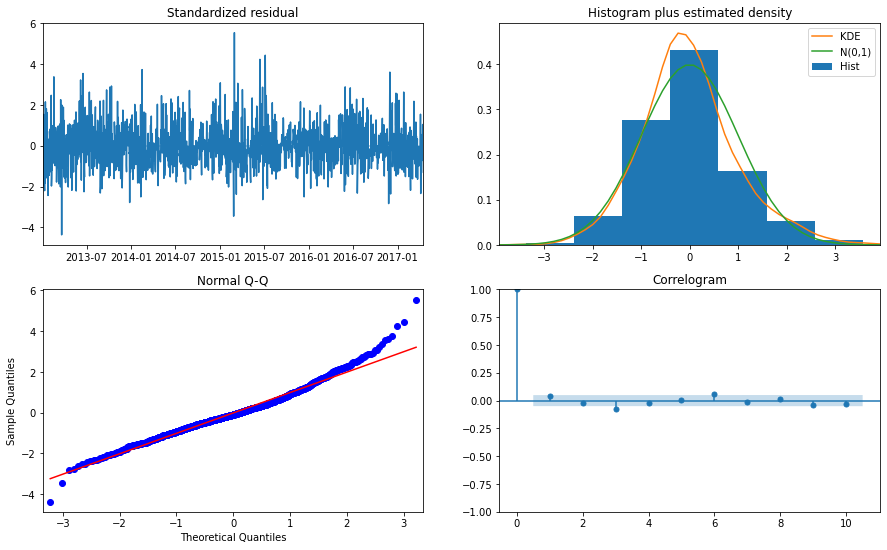

In [11]:
# residual analysis 
resids = model.plot_diagnostics(figsize=(15, 9)) 

The residual diagnostic plots seem to be well behaved for the most part where the residuals follow a Gaussian white noise process. 

---

<a name="2-1-3"></a> 

## Predict and Evaluate 7-Day Forecast 

In [12]:
# predict forecast 
y_pred = model.forecast(steps=7) 

# evaluation 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 60.95
RMSE = 7.81


<a name="2-1-4"></a> 

## Plot Predicted Forecast 

[Outline](#0) | [Summary](#4) 

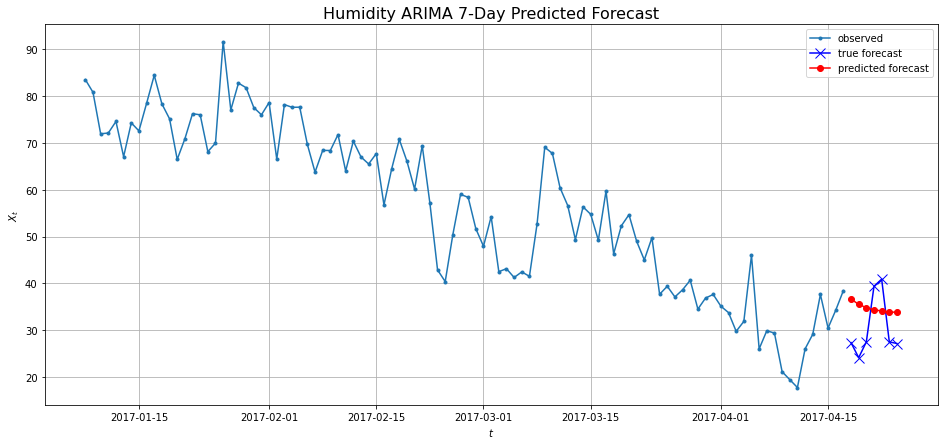

In [13]:
# plot forecast 
plot.time_series_forecast(signal=y_train.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Humidity ARIMA 7-Day Predicted Forecast', 
                          figsize=(16, 7)) 



--- 

<a name="2-2"></a> 

# 2.2 Recurrent Neural Network 

* [Outline](#0) 
* [Section 2 Outline](#2) 

---

## Topic Sections 

* [Create Sequences](#2-2-1) 
* [Define Model](#2-2-2) 
* [Fit Model](#2-2-3) 
* [Predict and Evaluate 7-Day Forecast](#2-2-4) 
* [Plot Predicted Forecast](#2-2-5) 

---

## Split Signal and Normalize 

Use all except the last 7 days for the train signal, keep the last week of the signal for forecasting. 

In [14]:
# extract humidity signal 
signal = df['humidity'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

<a name="2-2-1"></a> 

## Create Sequences 

To model time series data in neural networks, they need to be converted into sequences. The sequences and the response come from a sliding window that steps through time 1 time step at a time and uses a defined number of observations to predict the last value of the window. 

In [15]:
# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


<a name="2-2-2"></a> 

## Define Model 



In [16]:
# define model 
model = nnetfc.Recurrent() 
model.summary() 

Model: "Recurrent_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


<a name="2-2-3"></a> 

## Fit Model 

The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [17]:
# fit model 
_= nnetfc.fit(model, x_train, y_train, verbose=0) 

<a name="2-2-4"></a> 

## Predict and Evaluate 7-Day Forecast 

After the forecast has been predicted, the dates from the true future values will be used to align the forecast prediction and then all of the signals will be transformed back to original values to compute the mean squared error and visualize the forecast. 

In [18]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 116.1
RMSE = 10.77


<a name="2-2-5"></a> 

## Plot Predicted Forecast 

[Outline](#0) | [Summary](#4) 

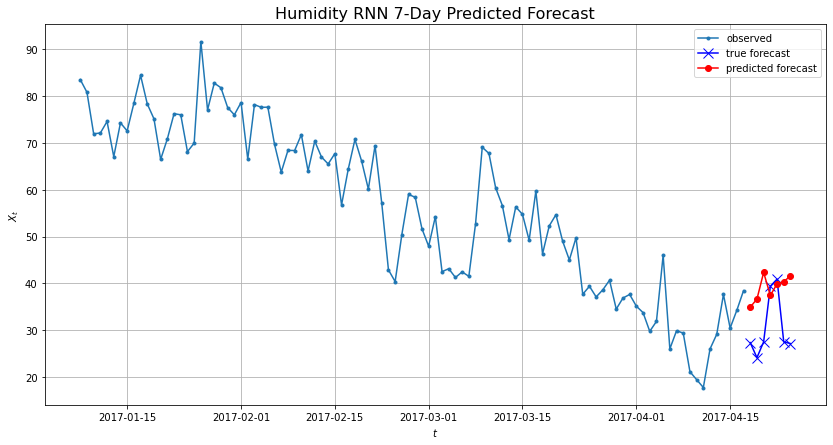

In [19]:
# plot forecast 
plot.time_series_forecast(signal=y.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Humidity RNN 7-Day Predicted Forecast') 



<a name="2-3"></a> 

# 2.3 Temporal Convolutional Network 

* [Outline](#0) 
* [Section 2 Outline](#2) 

---

## Topic Sections 

* [Define Model](#2-3-1) 
* [Fit Model](#2-3-2) 
* [Predict and Evaluate 7-Day Forecast](#2-3-3) 
* [Plot Predicted Forecast](#2-3-4) 

---

## Preprocess Signal 

The preprocessing steps will be exactly the same as for the recurrent forecaster. 

In [20]:
# extract humidity signal 
signal = df['humidity'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


<a name="2-3-1"></a> 

## Define Model 

In [21]:
# define model 
model = nnetfc.Convolutional(time_steps) 
model.summary() 

Model: "Convolutional_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
MaxPool (MaxPooling1D)       (None, None, 32)          0         
_________________________________________________________________
Dense (Dense)                (None, None, 5)           165       
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           6         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<a name="2-3-2"></a> 

## Fit Model 

Fit exactly the same way as the recurrent forecaster. 

In [22]:
# fit model 
_= nnetfc.fit(model, x_train, y_train, verbose=0) 

<a name="2-3-3"></a> 

## Predict and Evaluate 7-Day Forecast 

After the forecast has been predicted, the dates from the true future values will be used to align the forecast prediction and then all of the signals will be transformed back to original values to compute the mean squared error and visualize the forecast. 

In [23]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 66.85
RMSE = 8.18


<a name="2-3-4"></a> 

## Plot Predicted Forecast 

[Outline](#0) | [Summary](#4) 

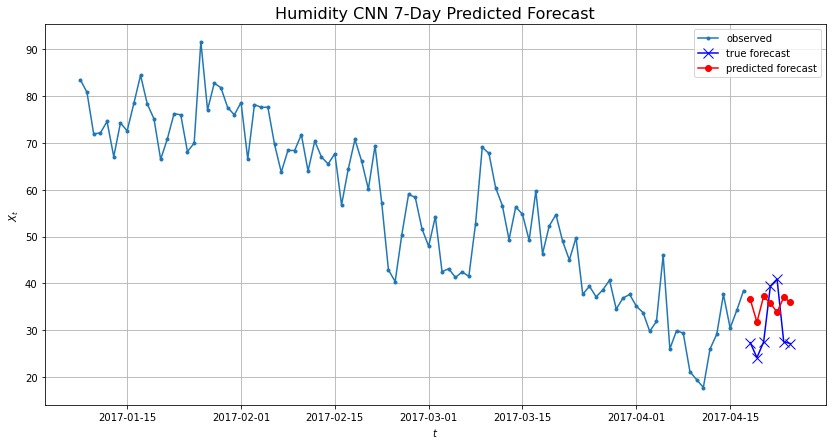

In [24]:
# plot forecast 
plot.time_series_forecast(signal=y.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Humidity CNN 7-Day Predicted Forecast') 



--- 

<a name="3"></a> 

# 3. Forecasting Wind Speed 

* [Outline](#0) 
* [Section 2 Outline](#2) 
* [Summary and Conclusion](#4) 

---

## Section Outline 

* [3.1 Autoregressive Integrated Moving Average](#3-1) 
* [3.2 Recurrent Neural Network](#3-2) 
* [3.3 Temporal Convolutional Network](#3-3) 

---

## Explore Wind Speed Signal 

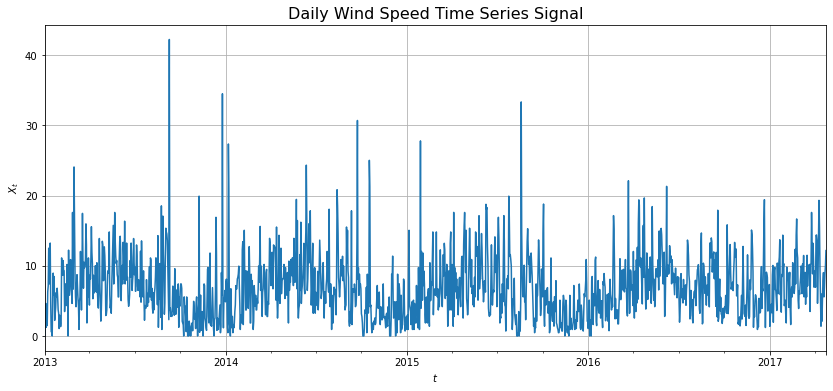

In [25]:
# extract wind speed signal 
y = df['wind_speed'].resample('D').mean() 
plot.signal_pd(y, title='Daily Wind Speed Time Series Signal') 

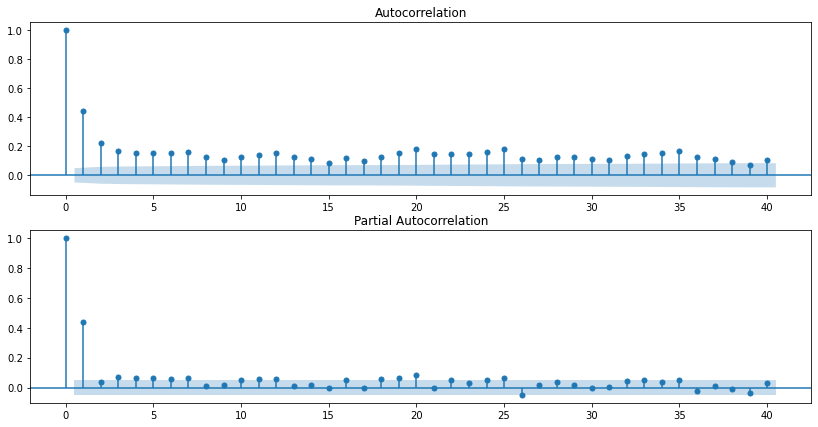

In [26]:
# plot ACF/PACF 
plot.p_acf(y, lags=40) 

The autocorrelation function and partial autocorrelation function indicate that there are no seasonal dependencies up to 40 lags. Since the data is collected daily, plot lags past a year to see if the data are periodic yearly. 

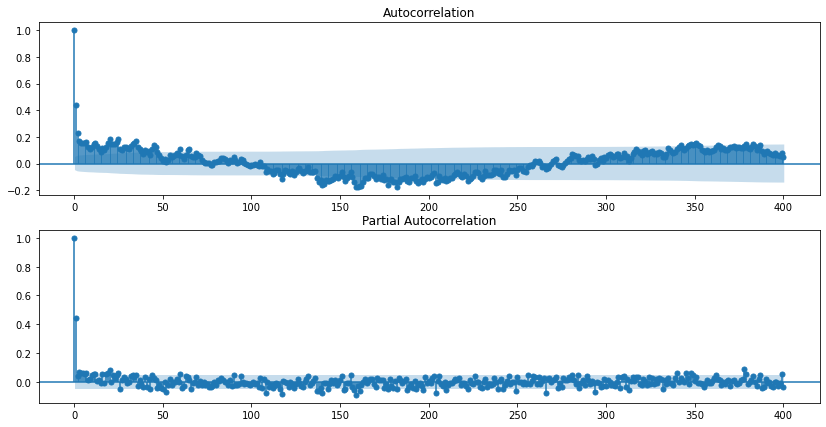

In [27]:
# plot ACF/PACF 
plot.p_acf(y, lags=400) 

There is still no indication of a seasonal dependency even though it looks like there would be in the time series plot. Test for stationarity with the Augmented Dickey Fuller test. 

In [28]:
# ADF test 
utils.ADF_test(y) 


Augmented Dickey-Fuller Test:

Test Statistic            -4.005864
p-val                      0.001380
Num. Lags                 24.000000
Num. Observations       1550.000000
Critical Value (1%)       -3.434576
Critical Value (5%)       -2.863406
Critical Value (10%)      -2.567764
dtype: float64

Conclusion:
The p-val <= 0.01 thus, the series is stationary


<a name="3-1"></a> 

# 3.1 Autoregressive Integrated Moving Average 

* [Outline](#0) 
* [Section 3 Outline](#3) 

---

## Topic Sections 

* [Define Model](#3-1-1) 
* [Evaluate Model](#3-1-2) 
* [Predict and Evaluate 7-Day Forecast](#3-1-3) 
* [Plot Predicted Forecast](#3-1-4) 

---

## Split Data 

In [29]:
# train and test data 
fc_hzn = 7 
y_train, y_test = sequence.temporal_split(y, fc_hzn) 

<a name="3-1-1"></a> 

## Define Model 

Since the ACF and PACF indicate no obvious seasonality, define an ARIMA model without a seasonal adjustment. The range of each parameter $(p, d, q)$ will be set to $[0, 2]$ and will run an automatic ARIMA function defined to fit all options of parameters. The model with the lowest AIC will be returned. 

In [30]:
# define and fit model 
model = arima.AutoARIMA(y_train, verbose=True) 

ARIMA(0, 0, 0)x(0, 0, 0, 0) | AIC = 11066.296812739136
ARIMA(0, 0, 1)x(0, 0, 0, 0) | AIC = 10122.081990253911
ARIMA(0, 1, 0)x(0, 0, 0, 0) | AIC = 9348.840443960242
ARIMA(0, 1, 1)x(0, 0, 0, 0) | AIC = 8950.261044766095
ARIMA(1, 0, 0)x(0, 0, 0, 0) | AIC = 9219.818063637254
ARIMA(1, 0, 1)x(0, 0, 0, 0) | AIC = 8956.30930066498
ARIMA(1, 1, 0)x(0, 0, 0, 0) | AIC = 9194.304868118772
ARIMA(1, 1, 1)x(0, 0, 0, 0) | AIC = 8790.294829328244
                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                 1568
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4392.147
Date:                Fri, 18 Sep 2020   AIC                           8790.295
Time:                        19:17:26   BIC                           8806.366
Sample:                    01-01-2013   HQIC                          8796.269
                         - 04-17-2017                                         
Covariance Typ

---

The ARIMA model parameters that yield the optimal AIC are $(p, d, q)=(1, 1, 1)$. 

---

<a name="3-1-2"></a> 

## Evaluate Model

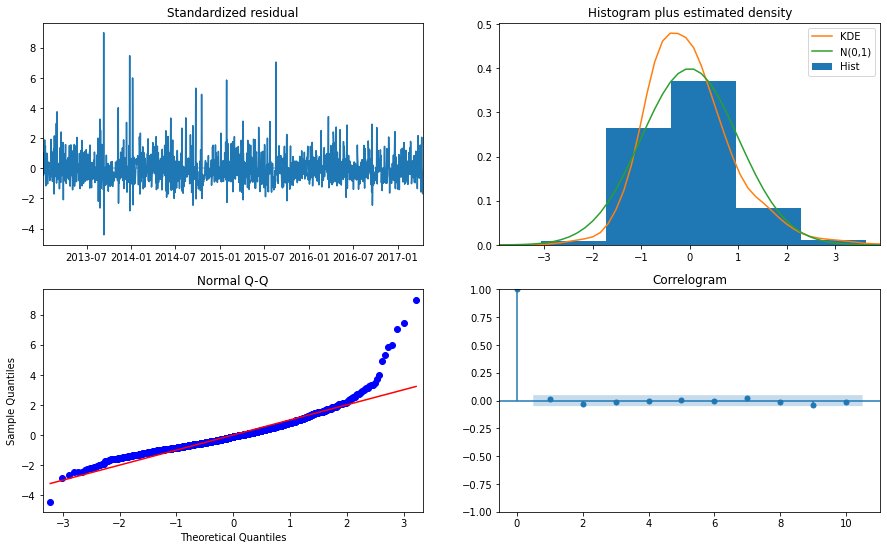

In [31]:
# residual analysis 
resids = model.plot_diagnostics(figsize=(15, 9)) 

The residual diagnostic plots seem to be well behaved for the most part where the residuals follow a Gaussian white noise process. 

---

<a name="3-1-3"></a> 

## Predict and Evaluate 7-Day Forecast 

In [32]:
# predict forecast 
y_pred = model.forecast(steps=7) 

# evaluation 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 3.7
RMSE = 1.92


<a name="3-1-4"></a> 

## Plot Predicted Forecast 

[Outline](#0) | [Summary](#4) 

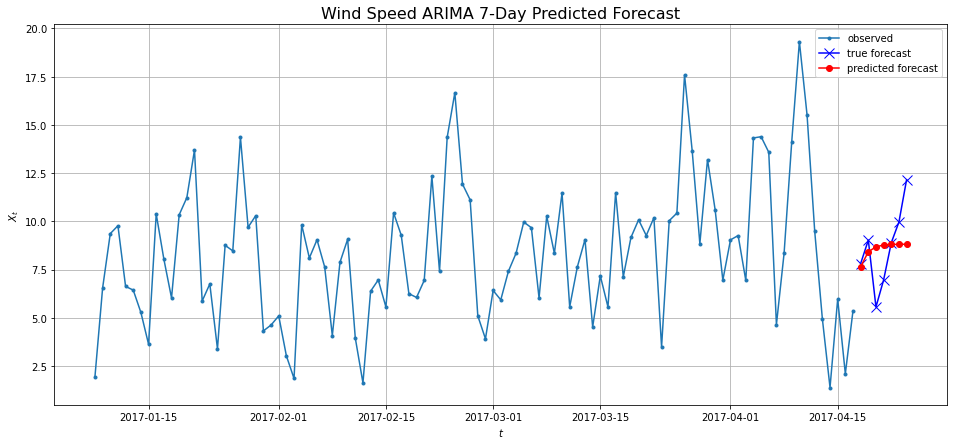

In [33]:
# plot forecast 
plot.time_series_forecast(signal=y_train.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Wind Speed ARIMA 7-Day Predicted Forecast', 
                          figsize=(16, 7)) 



--- 

<a name="3-2"></a> 

# 3.2 Recurrent Neural Network 

* [Outline](#0) 
* [Section 3 Outline](#3) 

---

## Topic Sections 

* [Create Sequences](#3-2-1) 
* [Define Model](#3-2-2) 
* [Fit Model](#3-2-3) 
* [Predict and Evaluate 7-Day Forecast](#3-2-4) 
* [Plot Predicted Forecast](#3-2-5) 

---

## Split Signal and Normalize 

Use all except the last 7 days for the train signal, keep the last week of the signal for forecasting. 

In [34]:
# extract humidity signal 
signal = df['wind_speed'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

<a name="3-2-1"></a> 

## Create Sequences 

To model time series data in neural networks, they need to be converted into sequences. The sequences and the response come from a sliding window that steps through time 1 time step at a time and uses a defined number of observations to predict the last value of the window. 

In [35]:
# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


<a name="3-2-2"></a>

## Define Model

In [36]:
# define model 
model = nnetfc.Recurrent() 
model.summary() 

Model: "Recurrent_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
GRU (GRU)                    (None, None, 20)          1380      
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________


<a name="3-2-3"></a>

## Fit Model

The model will be fit with early stopping where if there is no improvement in 50 epochs training will stop and the weights from the best epoch will be recovered. There will be a total of 1000 epochs so verbose will be set to 0 so it won't print a progress bar and the loss for every epoch. 

In [37]:
# fit model 
_= nnetfc.fit(model, x_train, y_train, verbose=0) 

<a name="3-2-4"></a> 

## Predict and Evaluate 7-Day Forecast 

After the forecast has been predicted, the dates from the true future values will be used to align the forecast prediction and then all of the signals will be transformed back to original values to compute the mean squared error and visualize the forecast. 

In [38]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 6.25
RMSE = 2.5


<a name="3-2-5"></a> 

## Plot Predicted Forecast

[Outline](#0) | [Summary](#4) 

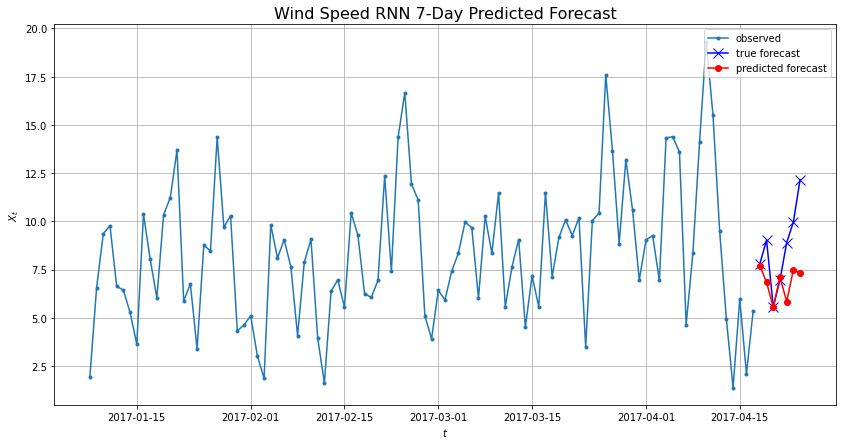

In [39]:
# plot forecast 
plot.time_series_forecast(signal=y.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Wind Speed RNN 7-Day Predicted Forecast') 

<a name="3-3"></a> 

# 3.3 Temporal Convolutional Network 

* [Outline](#0) 
* [Section 3 Outline](#3) 

---

## Topic Sections 

* [Define Model](#3-3-1) 
* [Fit Model](#3-3-2) 
* [Predict and Evaluate 7-Day Forecast](#3-3-3) 
* [Plot Predicted Forecast](#3-3-4) 

---

## Preprocess Signal 

The preprocessing steps will be exactly the same as for the recurrent forecaster. 

In [40]:
# extract humidity signal 
signal = df['wind_speed'].resample('D').mean() 

# split data 
fc_hzn = 7 
y, y_test = sequence.temporal_split(signal, fc_hzn) 

# normalize data 
y, norm = sequence.normalize_train(y) 
y_test = sequence.normalize_test(y_test, norm) 

# create sequences 
time_steps = 5 
x_train, y_train = sequence.xy_sequences(y, time_steps) 
print('x_train shape = {}'.format(x_train.shape)) 
print('y_train shape = {}'.format(y_train.shape)) 

x_train shape = (1563, 5, 1)
y_train shape = (1563, 1)


<a name="3-3-1"></a> 

## Define Model 

In [41]:
# define model 
model = nnetfc.Convolutional(time_steps) 
model.summary() 

Model: "Convolutional_Forecaster"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D (Conv1D)              (None, None, 32)          128       
_________________________________________________________________
MaxPool (MaxPooling1D)       (None, None, 32)          0         
_________________________________________________________________
Dense (Dense)                (None, None, 5)           165       
_________________________________________________________________
FC (TimeDistributed)         (None, None, 1)           6         
Total params: 299
Trainable params: 299
Non-trainable params: 0
_________________________________________________________________


<a name="3-3-2"></a> 

## Fit Model 

Fit exactly the same way as the recurrent forecaster. 

In [42]:
# fit model 
_= nnetfc.fit(model, x_train, y_train, verbose=0) 

<a name="3-3-3"></a> 

## Predict and Evaluate 7-Day Forecast 

After the forecast has been predicted, the dates from the true future values will be used to align the forecast prediction and then all of the signals will be transformed back to original values to compute the mean squared error and visualize the forecast. 

In [43]:
# predict forecast 
y_pred = nnetfc.predict_forecast(model, x_train, steps=fc_hzn) 
y_pred.index = y_test.index 

# transform to original values 
y = sequence.to_original_values(y, norm) 
y_test = sequence.to_original_values(y_test, norm) 
y_pred = sequence.to_original_values(y_pred, norm) 

# evaluate forecast 
fc_eval = ForecastEval(y_test, y_pred) 
fc_eval.mse() 

MSE = 8.33
RMSE = 2.89


<a name="3-3-4"></a> 

## Plot Predicted Forecast 

[Outline](#0) | [Summary](#4) 

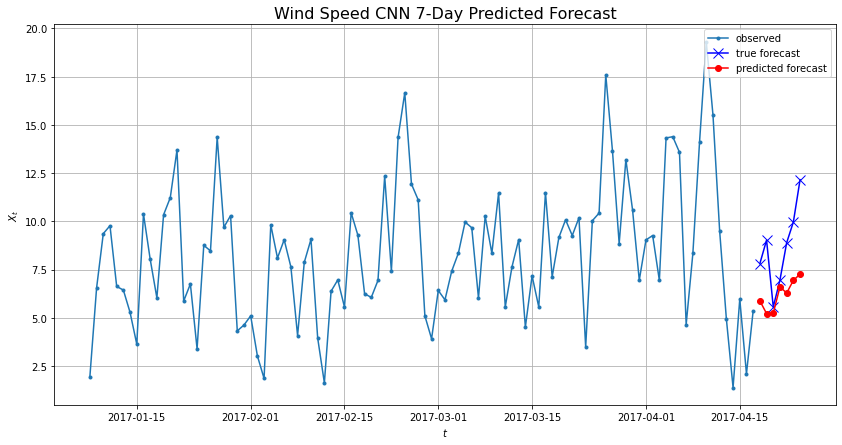

In [44]:
# plot forecast 
plot.time_series_forecast(signal=y.iloc[-100:], 
                          signal_test=y_test, 
                          p_forecast=y_pred, 
                          title='Wind Speed CNN 7-Day Predicted Forecast') 

---

<a name="4"></a> 

# 4. Summary and Conclusion 

* [Outline](#0) 
* [Forecasting Humidity](#2) 
* [Forecasting Wind Speed](#3) 

---

## Forecasting Humidity 

For forecasting humidity, exploratory analysis indicated that there is no seasonal component in the series based on the autocorrelation and partial autocorrelationn functions. The augmented Dickey Fuller test indicates that the time series is stationary so the ARIMA model without a seasonal adjustment is implemented. For neural networks, a recurrent neural network with one Gated Recurrent Unit (GRU) layer is implemented and a convolutional network with one temporal convolutional layer followed by a max pooling layer and a dense layer before it reaches the output layer. 

The mean squared error and root mean squared errors for all three models are summarized in the table below. 

| Model   | MSE    | RMSE   |
| :-----: | :----: | :----: |
| ARIMA   | 60.95  | 7.81   |
| RNN     | 116.10 | 10.77  |
| CNN     | 66.85  | 8.18   | 


---

## Forecasting Wind Speed 

For forecasting wind speed, exploratory analysis yields the same results as that of the humidity time series and thus, the wind speed time series does not have a seasonal dependency and it is stationary. The models implemented are exactly the same. 


The mean squared error and root mean squared errors for all three models are summarized in the table below. 

| Model   | MSE    | RMSE   |
| :-----: | :----: | :----: |
| ARIMA   | 3.7    | 1.92   |
| RNN     | 6.25   | 2.50   |
| CNN     | 8.33   | 2.89   |


---

## Conslusion 

Based on the MSE and RMSE, the ARIMA models had the best performance for both the humidity and wind speed time series. While that seems promising, the plots of the actual forecast yield interesting results. 

For the **humidity time series**, the ARIMA model results in the lowest MSE/RMSE but when viewing the predicted forecast it shows that the predictions essentially lie along the average between all the actual future observations. This is a good estimate and if prediction intervals were included in this study the points would likely fall within the confidence bounds. For predictions based purely off where the predicted points lie, the recurrent and convolutional neural networks yield predicted forecasts that appear to be much more realistic than the ARIMA forecast since the predictions do not essentially create a flat line through the center of the points. 

* [ARIMA Forecast](#2-1-4) 
* [RNN Forecast](#2-2-5)
* [CNN Forecast](#2-3-4) 

For the **wind speed time series**, the ARIMA model again results in the lowest MSE/RMSE. The predictions for two steps in the future for the ARIMA model are very accurate and account for the varying observations in the predictions but after the two steps it flattens out like it did for the humidity forecast. The recurrent and convolutional neural networks yield similar results as they did for humidity. There was more error in predictions but the predicted forecasts appear to be more realistic based purely off of the values of predictions. 

* [ARIMA Forecast](#3-1-4) 
* [RNN Forecast](#3-2-5)
* [CNN Forecast](#3-3-4) 

---

## Notes on Neural Networks in this Study 

* It is important to note that since the neural networks in this study are fitted from scratch each time in this notebook, the results of forecast and error will vary each time they are re-run because of the randomness of fitting the models. 
* If it was desired to yield the same results for every forecast, the fitted models must be saved so the learned parameters can be loaded. 